# Deep Learning in Health Care: diagnosing skin lesions

Early detection of melanoma, a type of skin cancer (<a href='https://en.wikipedia.org/wiki/Melanoma'>wikipedia page</a>), is critical, as the estimated five-year survival rate is only about 14% if detected in its latest stages instead of its early stages (survival rate of over 99%) (Esteva et al, 2017).

<img src="supplemental/illustration2.png" style="width:290px" align="right">

This notebook describes how to train a deep convolutional neural network (CNN) to diagnose skin lesions in an attempt to effectively increase the detections in early stages through an application. At the end of this notebook, you will be able to classify your own moles as either benign or malignant in similar fashion to professional dermatologists. 


The two main references of this notebook are the following research publication
- <a href='https://cs.stanford.edu/people/esteva/nature/'>Esteva et al - Dermatologist-level classification of skin cancer with deep neural network</a>

...and the Google Codelab on how to train the CNN:
- https://codelabs.developers.google.com/codelabs/tensorflow-for-poets/

For the implementation, we will use the research article as a guide. If another reference is used it will be clearly mentioned.

A great introduction to second opinions through artificial intelligence can be found in the following TED talk:

<a href='https://www.youtube.com/watch?v=cqmJkn6l1Jo'>Abdul Hamid Al Halabi - Cancer: Can Artificial Intelligence Provide a Second Opinion?</a>



<font size=1><i>illustration on the right is based on an image from vecteezy.com</i></font>

** Recommendations **

- some programming experience (Python)
- a little bit of experience with these notebooks (Jupyter Notebook)
- a little bit of command line experience
- the following python packages:

In [2]:
# dependencies
import json
from pprint import pprint
from matplotlib import pyplot as plt
import os
import shutil

import tensorflow
import tensorboard

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

- Lastly, also a MacOS / Linux machine is preferred as some python functions don't correspond with Windows functions and would have to be interchanged.

## 1. The data

In the research article, different sources of data were used. Because we are working on our personal machines, we have to limit the data in order to make the process computationally feasible. I have randomly selected and downloaded the following data from the <a href='https://isic-archive.com/#images'>ISIC Dermoscopic Archive</a>:

- ISIC_UDA-1_1
- ISIC_UDA-2_1
- ISIC_MSK-3_1
- ISIC_MSK-5_1

### 1.1 Download the data

To download the data, go to the <a href='https://isic-archive.com/#images'>ISIC Dermoscopic Archive</a> and go to 'Database Attributes' on the left and select the subsets. Next, on the top right there is a button that says 'Download as ZIP'. Download both the metadata and the image files. Unzip the .zip file into a new folder.
<img src='supplemental/ISIC.png'>

Information on how the diagnosis was assigned can be found on the website. 

### 1.2 Sort the data into the two classes

We want to separate the benign from the malignant image samples. We can find the diagnosis in the accompanying .json file for every image (metadata).

We start by listing all our downloaded files in the download directory.

In [3]:
def list_all_jpg_files(root):
    """List all the .jpg files in the folder and its subfolders."""
    all_files = list()
    for path, subdirs, files in os.walk(root):
        for name in files:
            file = os.path.join(path, name)
            if file.endswith('.jpg'):
                all_files.append(file)
    return all_files
        
all_jpg_files = list_all_jpg_files("data/ISIC-images/") # specify your directory here
print('{} .jpg files were found.'.format(len(all_jpg_files)))
all_jpg_files[0:10]

953 .jpg files were found.


['data/ISIC-images/ISIC_MSK-3_1/ISIC_0012435.jpg',
 'data/ISIC-images/ISIC_MSK-3_1/ISIC_0012384.jpg',
 'data/ISIC-images/ISIC_MSK-3_1/ISIC_0012390.jpg',
 'data/ISIC-images/ISIC_MSK-3_1/ISIC_0012151.jpg',
 'data/ISIC-images/ISIC_MSK-3_1/ISIC_0012179.jpg',
 'data/ISIC-images/ISIC_MSK-3_1/ISIC_0012233.jpg',
 'data/ISIC-images/ISIC_MSK-3_1/ISIC_0012227.jpg',
 'data/ISIC-images/ISIC_MSK-3_1/ISIC_0012232.jpg',
 'data/ISIC-images/ISIC_MSK-3_1/ISIC_0012187.jpg',
 'data/ISIC-images/ISIC_MSK-3_1/ISIC_0012178.jpg']

We define a function to load the .json file and show how it looks like:

In [4]:
def json_to_dict(json_filepath):
    """Loads .json file into a python dictionary."""
    with open(json_filepath) as data_file:    
        data = json.load(data_file)
    return data

pprint(json_to_dict("data/ISIC-images/ISIC_MSK-3_1/ISIC_0012089.json"))

{'_id': '57eea3319fc3c12a89bb4fdc',
 'meta': {'acquisition': {'image_type': 'dermoscopic',
                          'pixelsX': 4288,
                          'pixelsY': 2848},
          'clinical': {'age_approx': 45,
                       'benign_malignant': 'benign',
                       'diagnosis': 'nevus',
                       'diagnosis_confirm_type': 'histopathology',
                       'melanocytic': True,
                       'sex': 'female'}},
 'name': 'ISIC_0012089'}


Based on the previous function, we can load the .json file and determine whether it the corresponding image shows a benign skin lesion or a malignant sample. We test the function for a sample named 'ISIC_0012089' that appears to be not malignant, thus benign. 

In [5]:
def is_malignant(json_filepath):
    """Load corresponding json file and return True if the sample is malignant
    and False in the case of a benign sample
    
    This function uses the json_to_dict function."""
    # load file
    data = json_to_dict(json_filepath)
    
    # confirm diagnosis
    diagnosis = data['meta']['clinical']['benign_malignant']
    assert diagnosis == 'malignant' or diagnosis == 'benign', \
    'Diagnosis for sample {} is neither benign nor malignant'.format(json_filepath)
    
    # return
    if data['meta']['clinical']['benign_malignant'] == 'malignant':
        return True
    else:
        return False

is_malignant("data/ISIC-images/ISIC_MSK-3_1/ISIC_0012089.json")

False

Now that we have the above functions, we will sort the data in a new directory. We have to create a main data directory first that holds two folders, '/malignant' and '/benign':

In [6]:
# create the target directory
target_directory = 'data/skinlesion'
os.mkdir(target_directory)

# in this directory, we create a 'malignant' and 'benign' folder
os.mkdir(target_directory + '/malignant')
os.mkdir(target_directory + '/benign')

Using the is_malignant function defined above, we will check the .json files of every image and we will separate the malignant from the benign images in the respective directories. 

**NOTE: I am using os.path.basename() to extract the image name from the entire path. If you are using a Windows machine, you might have to replace this function with another to make it compatible.**

Sorting the images by placing them in either the malignant or benign folders. We also show the distributions afterwards:

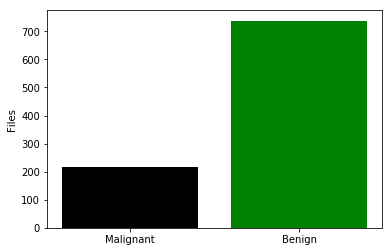

In [7]:
m,b = 0,0
# check every image
for jpg_file in all_jpg_files:
    # check the corresponding .json file of the .jpg
    json_file = jpg_file.replace('.jpg', '.json')
    if is_malignant(json_file):
        # copy the .jpg to /malignant if the sample is malignant
        shutil.copy(jpg_file, target_directory + '/malignant/' + os.path.basename(jpg_file))
        m += 1
    else:
        # copy the .jpg to /benign if the sample is benign
        shutil.copy(jpg_file, target_directory + '/benign/' + os.path.basename(jpg_file))
        b += 1
plt.bar([0,1], [m,b],tick_label=['Malignant', 'Benign'], align='center', color=['black','green'])
plt.ylabel('Files')
plt.show()

About 200 / 950 files are malignant skin lesions (21%), whereas the remaining 750 files are examples of benign lesions (79%).

**IMPORTANT:** Ideally, we would want to resample the dataset in order to balance the malignant and benign data entries. You can do this by for example oversampling the malignant entries or undersampling the benign entries. This is not illustrated in the notebook to keep this tutorial basic.

## 2. Deep convolutional neural network: Inception V3

The previous section is concluded by having two folders with skin lesion images. One folder containing about 200 examples of malignant lesions, whereas the other folder contains 750 harmless (benign) examples.

### 2.1 Introduction

In this subsection convolutional neural networks are introduced and more specific the Inception V3 model.

If you are not yet familiar with neural networks in general, it should not be a problem since you can just follow the implementation. However, to understand the concepts it is recommended to watch an introduction. For example <a href="https://youtu.be/P2HPcj8lRJE">here on Youtube</a>.

#### About convolutional neural networks


Convolutional Neural Networks are very similar to ordinary Neural Networks: they are also made up of neurons that have learnable weights and biases. Each neuron receives some inputs, performs a dot product and optionally follows it with a non-linearity. (<a href="http://cs231n.github.io/convolutional-networks/">ref</a>)


A convolutional neural network finds distinct patterns in the data (i.e. image), just like our eyes can. It finds these small, typical patterns and pieces them together to come to a conclusion about the entire picture. It essentially creates features that we would otherwise have to hand-craft. What the 'convolutional' in CNN actually means, is that in this process, 'filters' are applied on pieces of a preceding matrix and the filter output is saved as a new value (feature) in the next matrix. This is extremely well described in <a href="https://adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks-Part-2/">part 2 of this tutorial</a>. Part 1 of the same tutorial can be found <a href="https://adeshpande3.github.io/adeshpande3.github.io/A-Beginner's-Guide-To-Understanding-Convolutional-Neural-Networks/">here</a>. 

Taken from wikipedia:

"Convolutional layers apply a convolution operation to the input, passing the result to the next layer. The convolution emulates the response of an individual neuron to visual stimuli."

A very informative and more elaborate introductory video to CNNs can be found <a href="https://www.youtube.com/watch?v=FmpDIaiMIeA">here on Youtube</a>.

#### Inception V3

The deep convolutional neural network that we will use is the GoogleNet Inception v3 CNN architecture (Google Brain). This neural network was pre-trained to 93.33% top-five accuracy on approximately 1.28 million images, downloaded from the 2014 ImageNet Large Scale Visual Recognition Challenge. 

The neural network is pre-trained. Therefore we have to apply 'transfer learning' to make this model recognize malignant skin lesions in a group of benign examples. In essence, we reuse the trained model for a different purpose.

What this 'transfer learning' means in practice is that we will retrain the very last layer of the following network:
<img src="supplemental/inception_v3_architecture.png">
The reason that we use this pre-trained network is because training a network of this size from scratch may take days or even weeks, depending on your setup. This would take a lot of time and effort; both of which you probably don't have. If you would still like to know how to train from scratch, it is explained <a href='https://github.com/tensorflow/models/tree/master/research/inception'>here</a>. A fully trained model is very likely going to perform even better.


The deeper we go in the network, the more complicated the features become. The very first layers contribute to **edge detection**. The next layers will use the edges to **detect shapes**. With these shapes, we can **detect more abstract objects**. Finally, the last layer is a Softmax layer that outputs the probabilities for our classes.
<img src="supplemental/inception_v3_architecture2.png">

Figure references:
- <a href="https://codelabs.developers.google.com/codelabs/cpb102-txf-learning/index.html?index=..%2F..%2Findex#2"> Image Classification Transfer Learning with Inception v3 </a>
- <a href="https://www.tensorflow.org/tutorials/image_retraining">TensorFlow: How to Retrain Inception's Final Layer for New Categories</a>

### 2.2 Downloading the Tensorflow example repository

In this notebook, we will make use of the Github repository uploaded on <a href='https://github.com/googlecodelabs/tensorflow-for-poets-2'>'googlecodelabs'</a>. This repository shows how to retrain the last layer of the CNN to classify flower images. In this notebook, we will retrain the last layer to classify images of skin lesions as either 'benign' or 'malignant'. 


You can either manually download the repository or use the Git **clone** command.

Specify the download directory here:

In [ ]:
tensorflow_dir = '/tensorflow-for-poets-2'

Before going further, we will rename the directory to something more clear and specific.

In [14]:
os.rename('tensorflow-for-poets-2', 'tensorflow_skinlesion')

### 2.3 Moving our training data to the tensorflow folder

We will now move the 'skinlesion' folder containing the two subfolders 'malignant' and 'benign' to the empty tf_files folder in the freshly downloaded repository. 

In [1]:
try:
    shutil.move(target_directory, 'tensorflow_skinlesion/tf_files/skinlesion')
except:
    print('Directory probably already moved.')

### 2.4 Retraining the last layer of the CNN

As the original article suggests, we will use the InceptionV3 model. 

Because the modules in the repository are quite large in size, I won't copy or refer to the scripts in the notebook, but we will execute the commands through the command line. You will probably have to use your common sense and try a little bit to get it to work.

First of all, we will enable the included TensorBoard tool. This tool allows us to analyze our network after training.

**NOTE: because the training only needs to be done once and the TensorFlow python scripts work out of the box, I did not pour the original files into a notebook-importable class. The following sections print out the Unix commands that should be copy-pasted into the terminal in order to retrain the last layer of the model.**

In [3]:
print('Copy the following into the terminal:\n')
print("tensorboard --logdir tf_files/training_summaries &")

Copy the following into the terminal:

tensorboard --logdir tf_files/training_summaries &


Change your directory to the tensorflow_skinlesion folder.

In [4]:
print('Copy the following into the terminal:\n')
print('cd /Users/simonplovyt/stack/Projects/Deep\ Learning\ in\ Healthcare/tensorflow_skinlesion')

Copy the following into the terminal:

cd /Users/simonplovyt/stack/Projects/Deep\ Learning\ in\ Healthcare/tensorflow_skinlesion


Before we run the training process, we need to specify the 'training steps' parameter. If you dont have much time to train the model, leave the "amount of training steps" to 500. Otherwise, select a higher number, for example 4000. The higher the better, but the longer the training time. 

In [6]:
training_steps = 500

Some additional parameters (ref: https://www.tensorflow.org/tutorials/image_retraining):
- **Learning rate**: controls the magnitude of the updates to the final layer during training. The smaller this is, the longer the training will take, but can help the overall precision. It might also be disadvantageous, so you need to experiment carefully. 
- **Train batch size**: How many images are examined during one training step. The learning rate is applied per batch, so we'll have to reduce it if we have larger batches to get the same overall effect. 
- **Testing percentage**: The percentage of images to leave out of the training and to use as 'real-world' examples to check the generalized accuracy of the model.
- **Validation percentage**: The percentage of images to leave out of the training and to use as set to estimate parameters on. 
- **Print misclassified test images**: Print out the misclassified images for manual evaluation.

- **Random crop, random scale and random brightness adjustments**: Perform these operations on the images to get a broader and more random range of training samples. This will likely improve the performance of the model. However, by default disabled and we leave it like this for now. 

In [40]:
learning_rate = 0.1
train_batch_size = 100
testing_percentage = 10
validation_percentage = 10
print_misclassified_test_images = False

# if the images should be randomly cropped, scaled or changed in brightness (see 1.4 Final remarks)
random_crop = 0 
random_scale = 0
random_brightness = 0

Execute the retraining script:

In [41]:
print('Copy the following into the terminal:\n')
print("python3 -m scripts.retrain \
  --bottleneck_dir=tf_files/bottlenecks \
  --how_many_training_steps={} \
  --learning_rate={} \
  --train_batch_size = {} \
  --testing_percentage={} \
  --validation_percentage={} \
  --print_misclassified_test_images = {} \
  --random_crop = {} \
  --random_scale = {} \
  --random_brightness = {} \
  --model_dir=tf_files/models/ \
  --summaries_dir=tf_files/training_summaries/inception_v3 \
  --output_graph=tf_files/retrained_graph.pb \
  --output_labels=tf_files/retrained_labels.txt \
  --architecture=inception_v3 \
  --image_dir=tf_files/skinlesion".format(training_steps, learning_rate, train_batch_size, testing_percentage, 
                                          validation_percentage, print_misclassified_test_images, random_crop, 
                                          random_scale, random_brightness))

Copy the following into the terminal:

python3 -m scripts.retrain   --bottleneck_dir=tf_files/bottlenecks   --how_many_training_steps=500   --learning_rate=0.1   --train_batch_size = 100   --testing_percentage=10   --validation_percentage=10   --print_misclassified_test_images = False   --random_crop = 0   --random_scale = 0   --random_brightness = 0   --model_dir=tf_files/models/   --summaries_dir=tf_files/training_summaries/inception_v3   --output_graph=tf_files/retrained_graph.pb   --output_labels=tf_files/retrained_labels.txt   --architecture=inception_v3   --image_dir=tf_files/skinlesion


**function of the retrain.py script**

- First, this code will start with downloading the Inception model (inception-2015-12-05).
- Secondly, the layer before the actual Softmax classification layer is also called the 'bottleneck'. This is the layer that needs to output a set of values that contains all the information produced by the previous layers (edges, shapes, objects, etc ...). The output of this bottleneck is fed to the Softmax layer to calculate the probabilities of every class. That means it has to be a meaningful and compact summary of the images, since it has to contain enough information for the classifier to make a good choice in a very small set of values. For every image, a bottleneck file needs to be created. This process takes quite some time, but only has to be completed once. 
- Next, using the bottleneck files and the actual labels, the training of the last layer is started. While training, the algorithm attempts to minimize the cross-entropy metric. This is a measure for how well the model fits the data. 


*ref: https://www.tensorflow.org/tutorials/image_retraining *

**output with 500 steps**

** output with 10.000 steps **

However, every run is different.

**Tensorboard training analysis **

In orange, the values for the **training** set are plotted. Whereas in blue, the values for the **validation** set are shown.

- Accuracy
<img src="supplemental/accuracy.png">

- Cross entropy
<img src="supplemental/cross_entropy.png">

### 2.5 Using the retrained model to predict your own images. 

To get the label_image.py script working, we need to replace the line **input_layer = "input"** with **input_layer = "Mul"** at line 77. Also, the InceptionV3 model uses input images with **height and width both equal to 299** instead of 224. 

Because the label_image.py did not work out of the box like the other files (see reasons above), I have edited the file and poured it into a class so it is usable through notebook. Please download the new label_image.py file <a href="label_image.py" download>here</a> and replace it with the old label_image.py file in the scripts folder. 

In [2]:
from tensorflow_skinlesion.scripts import label_image

**Diagnosis of a training file:**

In [3]:
# initialisation
clf = label_image.label_image()

- Benign example

In [4]:
clf.classify(file_name='tensorflow_skinlesion/tf_files/skinlesion/benign/ISIC_0000008.jpg',
            model_file='tensorflow_skinlesion/tf_files/retrained_graph.pb',
            label_file='tensorflow_skinlesion/tf_files/retrained_labels.txt')

{'benign': 0.99821728, 'malignant': 0.001782719}

- Malignant example

In [5]:
clf.classify(file_name='tensorflow_skinlesion/tf_files/skinlesion/malignant/ISIC_0000046.jpg',
            model_file='tensorflow_skinlesion/tf_files/retrained_graph.pb',
            label_file='tensorflow_skinlesion/tf_files/retrained_labels.txt')

{'benign': 0.080981337, 'malignant': 0.91901863}

** Diagnosis of my own file:**

{'benign': 0.98634285, 'malignant': 0.013657195}


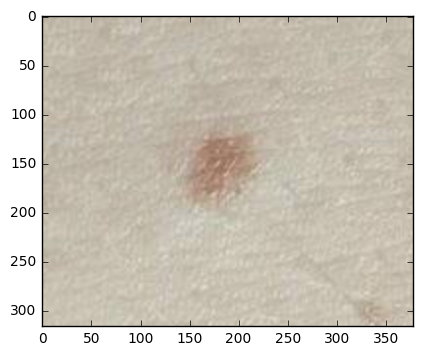

In [6]:
%matplotlib inline
diagnosis = clf.classify(file_name='tensorflow_skinlesion/tf_files/testfiles/1.png',
            model_file='tensorflow_skinlesion/tf_files/retrained_graph.pb',
            label_file='tensorflow_skinlesion/tf_files/retrained_labels.txt')
print(diagnosis)

img=mpimg.imread('tensorflow_skinlesion/tf_files/testfiles/1.png')
imgplot = plt.imshow(img)

{'benign': 0.99801314, 'malignant': 0.0019868352}


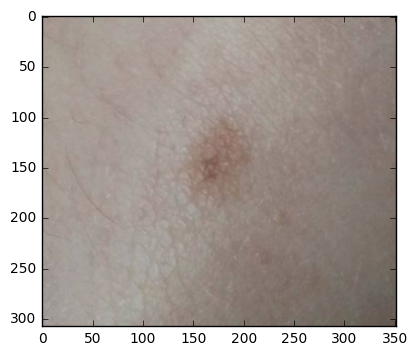

In [7]:
%matplotlib inline
diagnosis = clf.classify(file_name='tensorflow_skinlesion/tf_files/testfiles/2.png',
            model_file='tensorflow_skinlesion/tf_files/retrained_graph.pb',
            label_file='tensorflow_skinlesion/tf_files/retrained_labels.txt')
print(diagnosis)

img=mpimg.imread('tensorflow_skinlesion/tf_files/testfiles/2.png')
imgplot = plt.imshow(img)

With the following function we can also recalculate the training accuracy:

In [25]:
def accuracy_analysis(benign_folder, malignant_folder, model, min_malignant_threshold=0.5,
                      show_misclassified_malignant = False):
    """This function prints out the accuracies for both the benign and the malignant samples. In addition,
    it also returns the diagnosis and names of the misclassified malignant files."""
    clf = model
    
    # benign
    benign_files = list_all_jpg_files(benign_folder)
    correct_b = 0
    total_b = 0
    for file in benign_files:
        diagnosis = clf.classify(file_name=file,
            model_file='tensorflow_skinlesion/tf_files/retrained_graph.pb',
            label_file='tensorflow_skinlesion/tf_files/retrained_labels.txt')
        if diagnosis['malignant'] < min_malignant_threshold:
            correct_b += 1
        total_b += 1
    
    # malignant
    misclassified_malignant = list()
    malignant_files = list_all_jpg_files(malignant_folder)
    correct_m = 0
    total_m = 0
    for file in malignant_files:
        diagnosis = clf.classify(file_name=file,
            model_file='tensorflow_skinlesion/tf_files/retrained_graph.pb',
            label_file='tensorflow_skinlesion/tf_files/retrained_labels.txt')
        if diagnosis['malignant'] >= min_malignant_threshold:
            correct_m += 1
        elif show_misclassified_malignant:
            misclassified_malignant.append([os.path.basename(file), diagnosis])
        total_m += 1
    
    print('Benign accuracy: {}/{} [{}%]'.format(correct_b, total_b, round(correct_b*100/total_b,2)))
    print('Malignant accuracy: {}/{} [{}%]'.format(correct_m, total_m, round(correct_m*100/total_m,2)))
    print('Total training accuracy: {}/{} [{}%]'.format((correct_m + correct_b),(total_b+total_m),
                                                        round((correct_b+correct_m)*100/(total_b+total_m),2)))
    return misclassified_malignant

In [26]:
%%time
misclassified_malignant_samples = accuracy_analysis("tensorflow_skinlesion/tf_files/skinlesion/benign", 
                                                    "tensorflow_skinlesion/tf_files/skinlesion/malignant", 
                                                    model = label_image.label_image(), 
                                                    min_malignant_threshold=0.5, 
                                                    show_misclassified_malignant = True)

Benign accuracy: 704/738 [95.39%]
Malignant accuracy: 194/215 [90.23%]
Total training accuracy: 898/953 [94.23%]
CPU times: user 1h 25min 1s, sys: 11min 51s, total: 1h 36min 53s
Wall time: 1h 18min 42s


Visualizing the training accuracy:

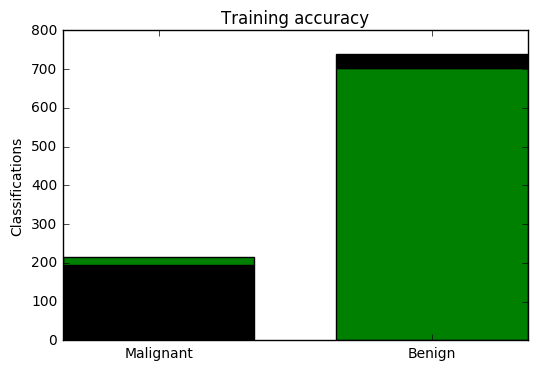

In [30]:
import numpy as np
import matplotlib.pyplot as plt

correct_clf = (194, 704)
wrong_clf = (21, 34)
width = 0.7

p1 = plt.bar([0,1], correct_clf, width, tick_label=['Malignant', 'Benign'], align='center', color=['black','green'])
p2 = plt.bar([0,1], wrong_clf, width,
             bottom=correct_clf, tick_label=['Malignant', 'Benign'], align='center', color=['green','black'])

plt.ylabel('Classifications')
plt.title('Training accuracy')
plt.show()

By default, we will classify every observation as malignant when the probability (denoted P(...)) of a malignant sample is larger than 0.5. This means that the threshold that separates benign from malignant is exactly 0.5 by default.

- P(malignant) >= 0.5 : MALIGNANT
- P(malignant) < 0.5 : BENIGN

Because we only have two classes, the probabilities of benign and malignant are complementary (P(malignant) + P(benign) = 1). This means we can write the above as:

- P(benign) < 0.5 : MALIGNANT
- P(benign) >= 0.5 : BENIGN

In practice however, we prefer to flag a skin lesion as malignant rather than benign when we are unsure. This will result in detecting more of the malignant samples, but also misclassifying more benign samples as malignant. 

"Better safe than sorry" fits here perfectly. This is exactly what we want in this case.

In order to achieve this, we will lower the threshold for the probability to classify a sample as malignant. This will **increase the sensitivity of the detection, also called 'recall'**. For example a threshold of 0.3 instead of 0.5:

- P(malignant) >= 0.3 : MALIGNANT
- P(malignant) < 0.3 : BENIGN

The 'accuracy_analysis()' function returns the misclassified cases in the malignant category. We will make a scatter plot of P(malignant) of the wrongly classified truly malignant samples to see whether lowering the thresholds makes sense. If so, we will also be able to determine the minimum value for the threshold that still allows to detect all the malignant samples.

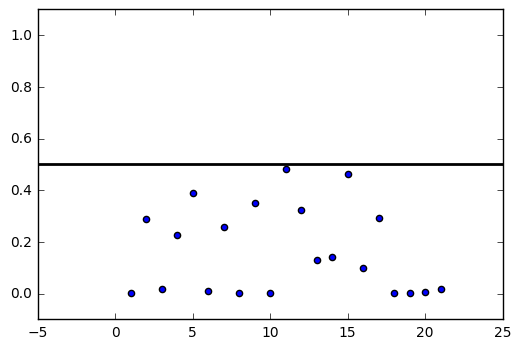

In [39]:
y_prob = list()
x_samples = list()
for i, m in enumerate(misclassified_malignant_samples):
    y_prob.append(m[1]['malignant'])
    x_samples.append(i+1)
plt.scatter(x_samples, y_prob)
plt.axhline(y=.5, linewidth=2, color = 'k')
plt.ylim(-0.1, 1.1)
plt.show()

The distribution of the probability of malignancy of the misclassified malignant skin lesions is spread from 0 to 0.5. There is no indication for a good threshold lower than 0.5 as there would be no sharp increase in recall without disturbing the benign classifications too much. 

## 3. Pouring the model into a mobile application

In reality, copy-pasting your own photographs and running the classification through the notebook is not very practical. Therefore, you might want to pour this trained neural net into an application. This way, you could take and analyze pictures on your phone. Unfortunately, the model is very big. Making users download 100 MB on their phone without even storing the application itself is a real project killer...

Fortunately, the downloaded repository comes with instructions and functionality to downsize the model from 32 bits to 8bits. This downsizing does effect the accuracy. However, neural networks are designed to deal with fuzzy and blurry inputs, so it is in fact possible to significantly decrease size without a big loss in accuracy.

Follow this Google codelab tutorial to find out how:

- <a href='https://codelabs.developers.google.com/codelabs/tensorflow-for-poets-2/#0'>Tensorflow for poets 2: Optimize for mobile</a>

*ref: <a href='https://www.youtube.com/watch?v=EnFyneRScQ8'>On-device machine learning: TensorFlow on Android (Google Cloud Next '17)</a>*

## 4. Final remarks

The testing accuracy of our CNN is 71%. This is a similar to the performance achieved in the research publication. 

I cite the following quote from the article:
>In this task, the CNN achieves 72.1 ±  0.9%  (mean ±   s.d.) overall accuracy (the average of individual inference class accuracies) and two dermatologists attain 65.56% and 66.0% accuracy on a subset of the validation set.

The CNN is on par with humans, which is an amazing result. 




We can still improve the accuracy by making some of the following adjustments:

- Resample the dataset to account for class imbalance (oversampling, undersampling, ...)
- Gather more data and run the process on a server.
- Retrain the entire network, not just the last layer.
- From the existing training files, generate synthetic training examples by adjusting some of the images.
- Try out a different CNN.
- Experiment with different training parameters.
- ...

Finally, I would like to express my gratitude to the authors of the research article. All credits go to Esteva et al.